In [29]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [31]:
# Load the dataset
data = pd.read_csv('/content/stock_dataset (1).csv')
print("Dataset Head:\n", data.head())

Dataset Head:
   symbol                       date   close    high       low    open  \
0   GOOG  2016-06-14 00:00:00+00:00  718.27  722.47  713.1200  716.48   
1   GOOG  2016-06-15 00:00:00+00:00  718.92  722.98  717.3100  719.00   
2   GOOG  2016-06-16 00:00:00+00:00  710.36  716.65  703.2600  714.91   
3   GOOG  2016-06-17 00:00:00+00:00  691.72  708.82  688.4515  708.65   
4   GOOG  2016-06-20 00:00:00+00:00  693.71  702.48  693.4100  698.77   

    volume  adjClose  adjHigh    adjLow  adjOpen  adjVolume  divCash  \
0  1306065    718.27   722.47  713.1200   716.48    1306065      0.0   
1  1214517    718.92   722.98  717.3100   719.00    1214517      0.0   
2  1982471    710.36   716.65  703.2600   714.91    1982471      0.0   
3  3402357    691.72   708.82  688.4515   708.65    3402357      0.0   
4  2082538    693.71   702.48  693.4100   698.77    2082538      0.0   

   splitFactor  
0          1.0  
1          1.0  
2          1.0  
3          1.0  
4          1.0  


In [32]:
# Handle missing values
data = data.fillna(method='ffill')

<ipython-input-32-21531d001e06>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


In [34]:

# Select relevant columns (example: Close and Volume for simplicity)
features = ['close', 'volume']
data = data[features]



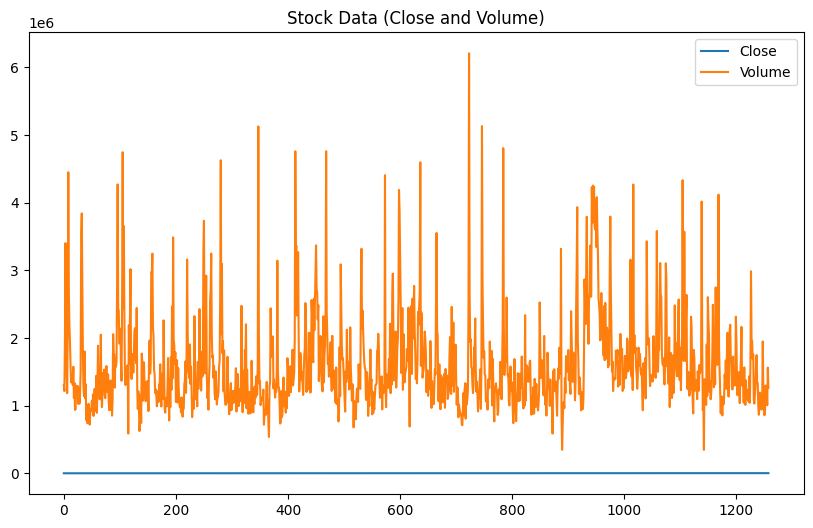

In [37]:
# Plot the raw data
plt.figure(figsize=(10, 6))
plt.plot(data['close'], label='Close')
plt.plot(data['volume'], label='Volume')
plt.title("Stock Data (Close and Volume)")
plt.legend()
plt.show()

In [38]:

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)


In [39]:
# Add lagged features to enhance predictive power
def add_lagged_features(data, lag_steps):
    df = pd.DataFrame(data, columns=['Close', 'Volume'])
    for lag in range(1, lag_steps + 1):
        df[f'Close_lag_{lag}'] = df['Close'].shift(lag)
        df[f'Volume_lag_{lag}'] = df['Volume'].shift(lag)
    df = df.dropna()  # Drop rows with NaN values
    return df.values

In [40]:

# Apply lagged features
lag_steps = 3
lagged_data = add_lagged_features(data.values, lag_steps)

# Re-normalize data with lagged features
scaled_lagged_data = scaler.fit_transform(lagged_data)

In [41]:
# Create sequences for multi-step forecasting
def create_sequences_multi_step(data, sequence_length, step_count):
    X, y = [], []
    for i in range(sequence_length, len(data) - step_count + 1):
        X.append(data[i-sequence_length:i, :])  # Input sequence
        y.append(data[i:i+step_count, 0])  # Future 'Close' values as output
    return np.array(X), np.array(y)

In [42]:
# Hyperparameters
sequence_length = 50  # Number of time steps in the input sequence
step_count = 3  # Number of future steps to predict


In [43]:
# Prepare the data
X, y = create_sequences_multi_step(scaled_data, sequence_length, step_count)

In [44]:
# Split into training and testing datasets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [45]:

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

Training data shape: (964, 50, 2), (964, 3)
Testing data shape: (242, 50, 2), (242, 3)


# 1. Vector Output Model

In [46]:
def create_vector_output_model(input_shape, output_steps):
    model = Sequential([
        LSTM(100, activation='tanh', input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(50, activation='tanh'),
        Dropout(0.2),
        Dense(output_steps)  # Output is a vector of future steps
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

In [47]:
# Train the Vector Output Model
vector_model = create_vector_output_model((X_train.shape[1], X_train.shape[2]), step_count)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_vector = vector_model.fit(X_train, y_train, epochs=50, batch_size=32,
                                   validation_data=(X_test, y_test),
                                   callbacks=[early_stopping], verbose=1)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0165 - val_loss: 0.0113
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0017 - val_loss: 0.0041
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0014 - val_loss: 0.0040
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 8.7217e-04 - val_loss: 0.0054
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0010 - val_loss: 0.0049
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 9.9662e-04 - val_loss: 0.0061
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.001

In [48]:
# Evaluate the Vector Output Model
y_pred_vector = vector_model.predict(X_test)
mse_vector = mean_squared_error(y_test, y_pred_vector)
mae_vector = mean_absolute_error(y_test, y_pred_vector)
rmse_vector = np.sqrt(mse_vector)
r2_vector = r2_score(y_test, y_pred_vector)
print(f"Vector Output Model Metrics - MSE: {mse_vector:.4f}, MAE: {mae_vector:.4f}, RMSE: {rmse_vector:.4f}, R²: {r2_vector:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Vector Output Model Metrics - MSE: 0.0015, MAE: 0.0307, RMSE: 0.0391, R²: 0.9483


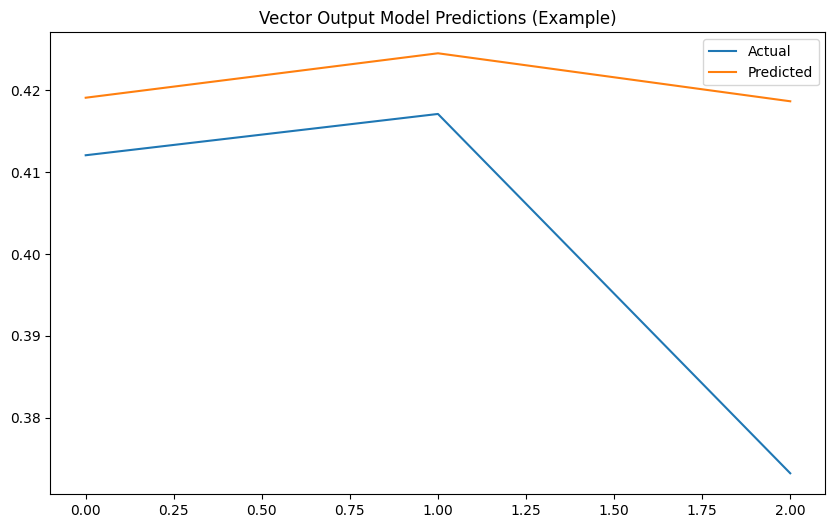

In [49]:
# Plot predictions for one example
plt.figure(figsize=(10, 6))
plt.plot(y_test[0], label='Actual')
plt.plot(y_pred_vector[0], label='Predicted')
plt.title("Vector Output Model Predictions (Example)")
plt.legend()
plt.show()


# 2. Encoder-Decoder Model

In [55]:
def create_encoder_decoder_model(input_shape, output_steps):
    model = Sequential([
        LSTM(100, activation='tanh', input_shape=input_shape),
        Dropout(0.2),
        RepeatVector(output_steps),  # Repeat the context vector
        LSTM(100, activation='tanh', return_sequences=True),
        Dropout(0.2),
        TimeDistributed(Dense(1))  # Predict each future step
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

In [56]:
# Train the Encoder-Decoder Model
encoder_decoder_model = create_encoder_decoder_model((X_train.shape[1], X_train.shape[2]), step_count)
history_encoder_decoder = encoder_decoder_model.fit(
    X_train, y_train.reshape(-1, step_count, 1),
    epochs=50, batch_size=32, validation_data=(X_test, y_test.reshape(-1, step_count, 1)),
    callbacks=[early_stopping], verbose=1)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0212 - val_loss: 0.0464
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0040 - val_loss: 0.0076
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0012 - val_loss: 0.0098
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0010 - val_loss: 0.0056
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 8.0452e-04 - val_loss: 0.0042
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 7.6507e-04 - val_loss: 0.0051
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 8.5950e-04 - val_loss: 0.0051
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 6.8900e-04 - val_loss: 0.0049
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 7.3544e-04 - val_loss: 0.0040
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 5.8258e-04 - val_loss: 0.0055


In [57]:
# Evaluate the Encoder-Decoder Model
y_pred_encoder_decoder = encoder_decoder_model.predict(X_test).reshape(-1, step_count)
mse_encoder_decoder = mean_squared_error(y_test, y_pred_encoder_decoder)
mae_encoder_decoder = mean_absolute_error(y_test, y_pred_encoder_decoder)
rmse_encoder_decoder = np.sqrt(mse_encoder_decoder)
r2_encoder_decoder = r2_score(y_test, y_pred_encoder_decoder)
print(f"Encoder-Decoder Model Metrics - MSE: {mse_encoder_decoder:.4f}, MAE: {mae_encoder_decoder:.4f}, RMSE: {rmse_encoder_decoder:.4f}, R²: {r2_encoder_decoder:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
Encoder-Decoder Model Metrics - MSE: 0.0464, MAE: 0.1712, RMSE: 0.2153, R²: -0.5805


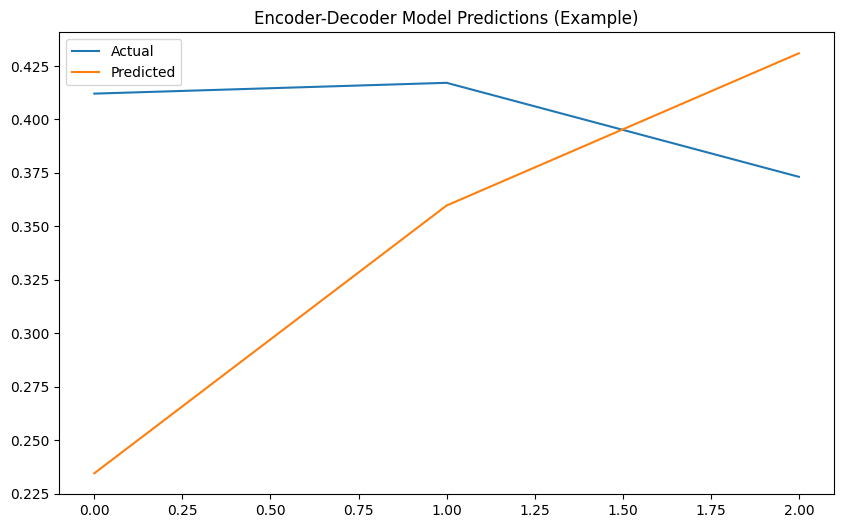

In [58]:
# Plot predictions for one example
plt.figure(figsize=(10, 6))
plt.plot(y_test[0], label='Actual')
plt.plot(y_pred_encoder_decoder[0], label='Predicted')
plt.title("Encoder-Decoder Model Predictions (Example)")
plt.legend()
plt.show()

In [59]:
# Compare Metrics
print("\nComparison of Multi-Step Models:")
print(f"Vector Output Model - MSE: {mse_vector:.4f}, MAE: {mae_vector:.4f}, RMSE: {rmse_vector:.4f}, R²: {r2_vector:.4f}")
print(f"Encoder-Decoder Model - MSE: {mse_encoder_decoder:.4f}, MAE: {mae_encoder_decoder:.4f}, RMSE: {rmse_encoder_decoder:.4f}, R²: {r2_encoder_decoder:.4f}")


Comparison of Multi-Step Models:
Vector Output Model - MSE: 0.0015, MAE: 0.0307, RMSE: 0.0391, R²: 0.9483
Encoder-Decoder Model - MSE: 0.0464, MAE: 0.1712, RMSE: 0.2153, R²: -0.5805
